In [1]:
from boxoffice.db.frames import get_wikipedia_day_frame, get_movie_frame_full

wdf = get_wikipedia_day_frame()
mdf = get_movie_frame_full()

MOVIES_DB_PATH: boxoffice/db/data/data.sqlite
MOVIES_DB_PATH: ../boxoffice/db/data/data.sqlite
movies.csv exists, 1730249436.6085198, 1730249400.3144891
Reading from movies.csv


In [19]:
# want to get the correlation between wikipedia views on any given day and the opening wide weekend box office for a film
# within wdf, create a new column that is the index of the day with respect to the movie
unique_movies = wdf['movie'].unique()

corr_wdf = wdf.copy(deep=True)

corr_wdf['day_index'] = 0
corr_wdf['opening_wide_revenue'] = 0
corr_wdf['total_revenue_within_365_days'] = 0

for movie in unique_movies:
    movie_wdf = wdf[wdf['movie'] == movie]
    movie_wdf =  movie_wdf.sort_values(by='date')
    movie_wdf = movie_wdf.reset_index(drop=True)
    movie_mdf = mdf[mdf['id'] == movie]
    if len(movie_mdf) == 0:
        continue
    # now write this back to the main dataframe
    corr_wdf.loc[corr_wdf['movie'] == movie, 'day_index'] = movie_wdf.index
    corr_wdf.loc[corr_wdf['movie'] == movie, 'opening_wide_revenue'] = movie_mdf['opening_wide_revenue'].values[0]
    corr_wdf.loc[corr_wdf['movie'] == movie, 'total_revenue_within_365_days'] = movie_mdf['total_revenue_within_365_days'].values[0]

# remove all rows where the opening wide revenue is 0
corr_wdf = corr_wdf[corr_wdf['opening_wide_revenue'] != 0]
corr_wdf = corr_wdf.reset_index(drop=True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
counts_per_day_index = corr_wdf.groupby('day_index').count()
print(counts_per_day_index)

# print the first day with under 50 movies
print(counts_per_day_index[counts_per_day_index['movie'] < 50].index[0])

            id  date  views  movie  opening_wide_revenue  \
day_index                                                  
0          906   906    906    906                   906   
1          906   906    906    906                   906   
2          906   906    906    906                   906   
3          906   906    906    906                   906   
4          906   906    906    906                   906   
...        ...   ...    ...    ...                   ...   
421         12    12     12     12                    12   
422         12    12     12     12                    12   
423         12    12     12     12                    12   
424         12    12     12     12                    12   
425         12    12     12     12                    12   

           total_revenue_within_365_days  
day_index                                 
0                                    906  
1                                    906  
2                                    906  
3   

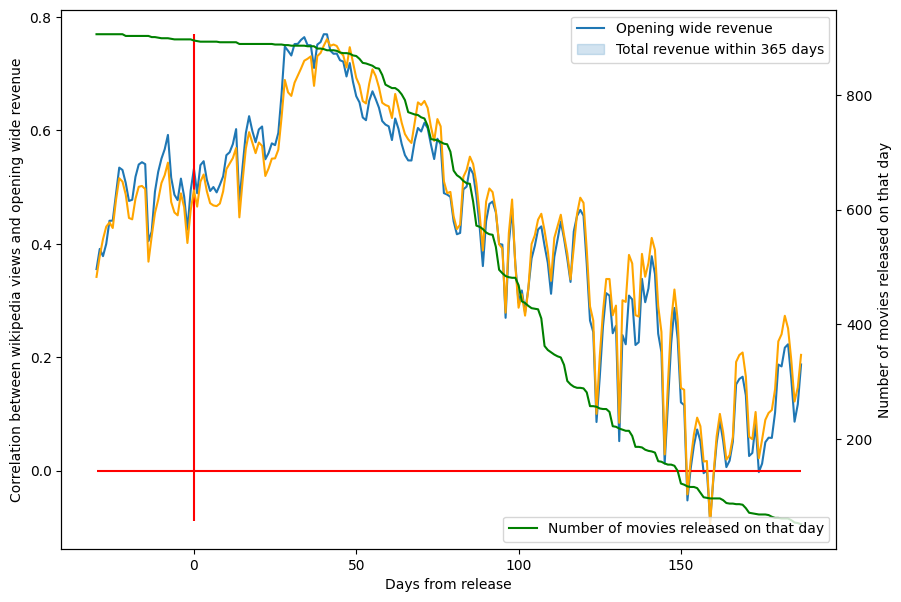

In [35]:
# group by day index and get the correlation between the two columns
# exclude non-numeric columns
numeric_corr_wdf = corr_wdf.select_dtypes(include=['number'])

correlation = numeric_corr_wdf.groupby('day_index').corr().loc[(slice(None), 'opening_wide_revenue'), 'views']
total_corr = numeric_corr_wdf.groupby('day_index').corr().loc[(slice(None), 'total_revenue_within_365_days'), 'views']

counts = numeric_corr_wdf.groupby('day_index').count()['views']

correlation_df = pd.DataFrame({'day_index': correlation.index.get_level_values(0), 'correlation': correlation.values, 'count': counts.values, 'total_corr': total_corr.values})
correlation_df['day_index'] = correlation_df['day_index'] - 30

# only go for days where we have at least 50 movies
correlation_df = correlation_df[correlation_df['count'] > 50]

# plot the correlation
plt.figure(figsize=(10, 7))
sns.lineplot(data=correlation_df, x='day_index', y='correlation')
plt.vlines(x=0, ymin=min(correlation_df['correlation']), ymax=max(correlation_df['correlation']), color='red')
plt.hlines(y=0, xmin=-30, xmax=max(correlation_df['day_index']), color='red')
plt.xlabel('Days from release')
plt.ylabel('Correlation between wikipedia views and opening wide revenue')

sns.lineplot(data=correlation_df, x='day_index', y='total_corr', color='orange')

plt.legend(['Opening wide revenue', 'Total revenue within 365 days'])
# also plot the count on a separate axis
plt.twinx()
sns.lineplot(data=correlation_df, x='day_index', y='count', color='green')
plt.ylabel('Number of movies released on that day')

plt.legend(['Number of movies released on that day'], loc='lower right')

In [33]:
# within movie df print the correlation between opening wide revenue and total revenue within 365 days
print(mdf[['opening_wide_revenue', 'total_revenue_within_365_days']].corr())

                               opening_wide_revenue  \
opening_wide_revenue                       1.000000   
total_revenue_within_365_days              0.936587   

                               total_revenue_within_365_days  
opening_wide_revenue                                0.936587  
total_revenue_within_365_days                       1.000000  
